In [59]:
import glob
import os 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam
from datetime import datetime
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


In [92]:
DATASET_PATH = r'C:\Users\HP\PycharmProjects\pythonProject7\brain_tumor'

images = [i for i in glob.glob(os.path.join(DATASET_PATH, "*/*"))]
np.random.shuffle(images)

# Extracting labels from the directory names
image_labels = [os.path.dirname(i).split("\\")[-1] for i in images]

In [93]:
#zip into df for visualization and stuff
image_with_labels = zip(images, image_labels)
cols = ["Images", "Labels"]
data_frame = pd.DataFrame(image_with_labels, columns = cols)

In [94]:
filepaths = []
labels = []

folds = os.listdir(DATASET_PATH)
for fold in folds:
    foldpath = os.path.join(DATASET_PATH , fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [95]:
df

,filepaths,labels
0,C:\Users\HP\PycharmProjects\pythonProject7\bra...,brain_tumor_dataset
1,C:\Users\HP\PycharmProjects\pythonProject7\bra...,brain_tumor_dataset
2,C:\Users\HP\PycharmProjects\pythonProject7\bra...,no
3,C:\Users\HP\PycharmProjects\pythonProject7\bra...,no
4,C:\Users\HP\PycharmProjects\pythonProject7\bra...,no
...,...,...
250,C:\Users\HP\PycharmProjects\pythonProject7\bra...,yes
251,C:\Users\HP\PycharmProjects\pythonProject7\bra...,yes
252,C:\Users\HP\PycharmProjects\pythonProject7\bra...,yes
253,C:\Users\HP\PycharmProjects\pythonProject7\bra...,yes


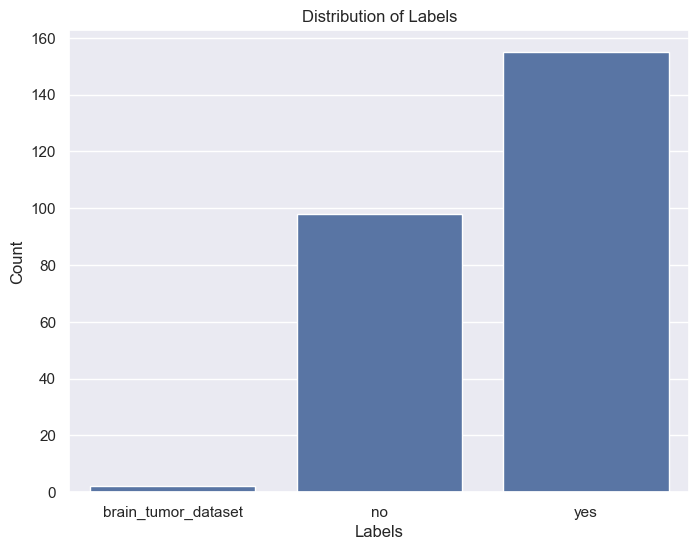

In [96]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))

# Plot the count of each label
sns.countplot(x="labels", data=df)

plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")

plt.show()

<Axes: xlabel='Labels', ylabel='count'>

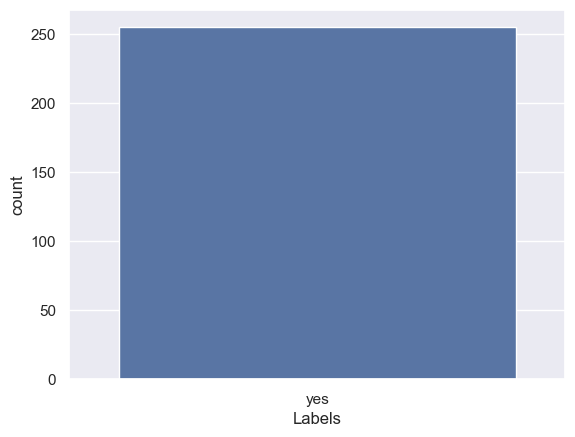

In [97]:
unique_labels = data_frame["Labels"].unique()
data_frame["Labels"] = pd.Categorical(data_frame["Labels"].replace(unique_labels))
sns.countplot(x = "Labels", data=data_frame)


Text(0.5, 1.0, 'Sample Image - Label: yes')

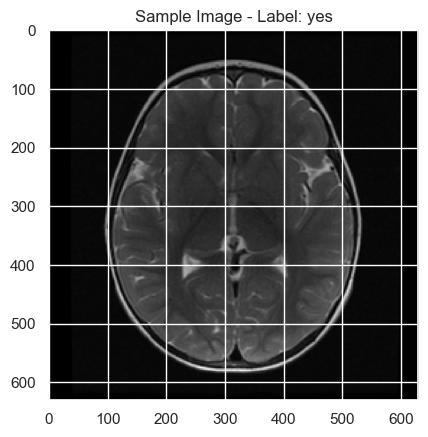

In [98]:
test_arr = plt.imread(data_frame.iloc[29]["Images"])
plt.imshow(test_arr)
plt.title(f"Sample Image - Label: {data_frame.iloc[29]['Labels']}")


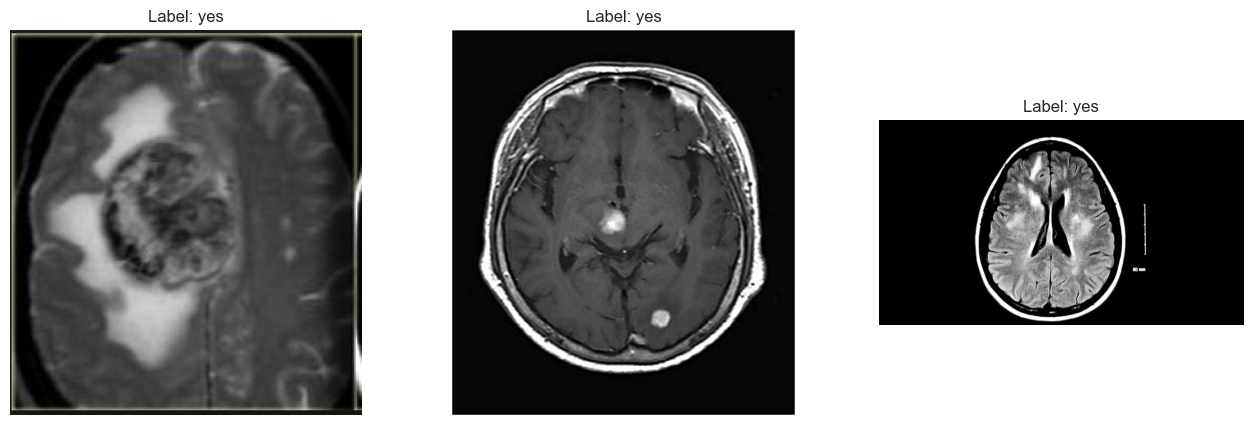

In [99]:
plt.figure(figsize=(16, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    img = plt.imread(data_frame.iloc[i]["Images"])
    plt.imshow(img)
    plt.title(f"Label: {data_frame.iloc[i]['Labels']}")
    plt.axis('off')  # Optionally, turn off axis for each subplot

plt.show()


In [100]:
#Rezise Images
imgs=(250, 250,1)

In [101]:
from sklearn.preprocessing import LabelEncoder
# Encode Labels
label_encoder = LabelEncoder()
data_frame["Encoded_Labels"] = label_encoder.fit_transform(data_frame["Labels"])

In [102]:
features = data_frame["Images"]
labels = data_frame["Encoded_Labels"]

feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [103]:
def preprocessor(image, label):
    # Randomly apply data augmentation techniques with a 20% probability
    apply_effect = tf.random.uniform([]) < 0.2

    # Read the image file
    image = tf.io.read_file(image)

    # Decode the JPEG image and convert it to grayscale
    image = tf.image.decode_jpeg(image, channels=1)

    # Resize the image to the desired size
    image = tf.image.resize(image, imgs[:2])

    # Randomly adjust the brightness of the image
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=(42, 101))

    # Randomly flip the image up or down
    image = tf.cond(
        apply_effect,
        lambda: tf.image.stateless_random_flip_up_down(image, seed=(42, 101)),
        lambda: image,
    )

    # Randomly flip the image left or right
    image = tf.cond(
        apply_effect,
        lambda: tf.image.stateless_random_flip_left_right(image, seed=(42, 101)),
        lambda: image,
    )

    # Normalize the image values to be between 0 and 1
    image = image / 255.0

    # Convert the label to a one-hot encoded vector
    label = tf.one_hot(label, depth=1)

    return image, label


In [104]:
# Create separate datasets for training and testing features and labels
feature_train_dataset = tf.data.Dataset.from_tensor_slices(feature_train)
label_train_dataset = tf.data.Dataset.from_tensor_slices(label_train)

feature_test_dataset = tf.data.Dataset.from_tensor_slices(feature_test)
label_test_dataset = tf.data.Dataset.from_tensor_slices(label_test)


In [105]:
train = tf.data.Dataset.zip((feature_train_dataset, label_train_dataset))
test = tf.data.Dataset.zip((feature_test_dataset, label_test_dataset))

train = train.map(preprocessor).batch(64).shuffle(128).prefetch(128)
test = test.map(preprocessor).batch(128).prefetch(128)



no_of_validation_images = len(test)
validation_steps = np.ceil(no_of_validation_images)

In [106]:
CNNmodel = Sequential()
CNNmodel.add(Conv2D(16, (2, 2), activation = "relu", input_shape = imgs))
CNNmodel.add(MaxPool2D((2, 2)))
CNNmodel.add(Conv2D(32, (2, 2), activation = "relu"))
CNNmodel.add(MaxPool2D((2, 2)))
CNNmodel.add(Conv2D(64, (2, 2), activation = "relu"))
CNNmodel.add(MaxPool2D((2, 2)))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(units = 128, activation = "relu"))
CNNmodel.add(Dense(units = 1, activation = "sigmoid"))

optimizer = Adam(learning_rate = 1e-5)
CNNmodel.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
CNNmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 249, 249, 16)      80        
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 124, 124, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 123, 123, 32)      2080      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 61, 61, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)        8256      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 64)       

In [108]:
es = EarlyStopping(patience = 3)
start = datetime.now()
CNNmodel.fit(train, validation_data = test, callbacks = [es], epochs = 25)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25


UnknownError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
NewRandomAccessFile failed to Create/Open: C:\Users\HP\PycharmProjects\pythonProject7\brain_tumor\brain_tumor_dataset\yes : Access is denied.
; Input/output error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_11029]

In [ ]:
import os

file_path = r'C:\Users\HP\PycharmProjects\pythonProject7\brain_tumor\brain_tumor_dataset\yes'

# Check if the file exists
if os.path.exists(file_path):
    # Check file permissions
    if os.access(file_path, os.R_OK):
        print(f"The file at {file_path} is accessible.")
    else:
        print(f"Error: No read access to the file at {file_path}.")
else:
    print(f"Error: The file at {file_path} does not exist.")

In [58]:
try:
    img = plt.imread(file_path)
except Exception as e:
    print(f"Error reading the file: {e}")

Error reading the file: [Errno 13] Permission denied: 'C:\\Users\\HP\\PycharmProjects\\pythonProject7\\brain_tumor\\brain_tumor_dataset\\yes'


In [40]:
import os

file_path = r'C:\Users\HP\PycharmProjects\pythonProject7\brain_tumor\brain_tumor_dataset\yes'

try:
    # Try to open the file in exclusive mode
    with open(file_path, 'rb') as f:
        # If the file is successfully opened, it is not locked
        print(f"The file at {file_path} is not locked.")
except IOError as e:
    # If IOError is raised, the file is locked
    print(f"The file at {file_path} is locked: {e}")


The file at C:\Users\HP\PycharmProjects\pythonProject7\brain_tumor\brain_tumor_dataset\yes is locked: [Errno 13] Permission denied: 'C:\\Users\\HP\\PycharmProjects\\pythonProject7\\brain_tumor\\brain_tumor_dataset\\yes'


In [ ]:
CNNmodel.evaluate(test)

In [ ]:
# Save the trained model
CNNmodel.save('brain_tumor_model.h5')
